## Notes
This file contains the ResNet18 model where we used Triplet Loss on the model, then we combined it with a K-Nearest Neighbour Classifier to classify the images. 

The idea is that we learn the image embeddings based on the distance metric from the anchor to positive and anchor to negative. After the model learns the similarity between images, we try to classify the images based on similarity of the test images to the trained KNN Classifier. 

In [1]:
!pip install torch
!pip install torchvision
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install scikit-learn

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable
from sklearn.neighbors import KNeighborsClassifier

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

### Data Transforms and regular dataset/dataloader

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

### Implementing a triplet dataset for Flowers 102

In this function, we are manipulating the flowers102 dataset to return the inputs in order of 3 for each data point. 

We arrange the data points to have the format of `(anchor image, positive image, negative image)`. 

In [6]:
from pathlib import Path
from typing import Any, Tuple, Callable, Optional
import random
import PIL.Image

class NewFlowers(torchvision.datasets.flowers102.Flowers102):
  def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
    super().__init__(root, split, transform, target_transform, download)
    self._labels = np.array(self._labels, dtype="int")
    
  def __getitem__(self, item):
    # Obtain indexes of all the labels
    index = np.array(list(range(0, len(self._labels))), dtype="int")
    
    # Obtain anchor image 
    anchor_img = self._image_files[item]
    anchor_img = PIL.Image.open(anchor_img).convert("RGB")
    
    # Obtain anchor label
    anchor_label = self._labels[item]

    # Generate positive index list where it is not the same class as the anchor
    positive_list = index[index!=item][self._labels[index!=item]==anchor_label]
    
    # Randomly obtain 1 positive item and its respective image
    positive_item = random.choice(positive_list)
    positive_img = self._image_files[positive_item]
    positive_img = PIL.Image.open(positive_img).convert("RGB")

    # Generate negative index list where it is not the same class as the anchor
    negative_list = index[index!=item][self._labels[index!=item]!=anchor_label]
    
    # Randomly obtain 1 negative item and its respective image
    negative_item = random.choice(negative_list)
    negative_img = self._image_files[negative_item]
    negative_img = PIL.Image.open(negative_img).convert("RGB")

    # Apply transformation on images
    anchor_img = self.transform(anchor_img)
    positive_img = self.transform(positive_img)
    negative_img = self.transform(negative_img)

    return (anchor_img, positive_img, negative_img), anchor_label

In [7]:
triplet_train = NewFlowers("./train", split="train", download=True, transform=data_transforms["train"])
triplet_val = NewFlowers("./train", split="val", download=False, transform=data_transforms["val"])
triplet_test = NewFlowers("./train", split="test", download=False, transform=data_transforms["test"])

We store the dataset in dataloaders, with batch size 4. 

In [8]:
triplet_train_dataloader = torch.utils.data.DataLoader(triplet_train, batch_size=4, shuffle=True)
triplet_val_dataloader = torch.utils.data.DataLoader(triplet_val, batch_size=4, shuffle=True)
triplet_test_dataloader = torch.utils.data.DataLoader(triplet_test, batch_size=4, shuffle=True)

In [9]:
image_datasets = {
    'train': triplet_train,
    'val': triplet_val,
    'test': triplet_test
}

dataloaders = {
    "train": triplet_train_dataloader,
    "val": triplet_val_dataloader,
    "test": triplet_test_dataloader,
}

dataset_sizes = {
    x: len(dataloaders[x].dataset)
    for x in list(image_datasets.keys())
}

In [10]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

### Function to show image

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Testing our triplet dataset

In [12]:
anchor, positive, negative = 0,0,0
for i, (inputs, labels) in enumerate(triplet_train_dataloader):
#     print(labels)
    anchor, positive, negative = inputs
    break

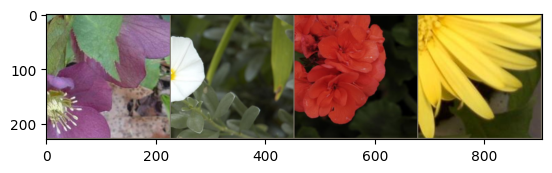

In [13]:
anchor_out = torchvision.utils.make_grid(anchor)
imshow(anchor_out)

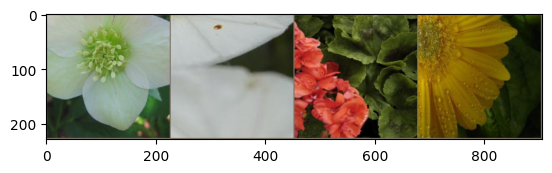

In [14]:
positive_out = torchvision.utils.make_grid(positive)
imshow(positive_out)

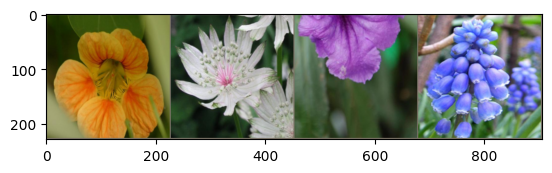

In [15]:
negative_out = torchvision.utils.make_grid(negative)
imshow(negative_out)

## General function to train the model.
We are using both `Triplet Loss` & `Cross Entropy Loss`. 

We pass the `anchor image`, `positive image`, and `negative image` into the `Triplet Loss` function to get the loss for the similarity between `anchor and positive image` and `anchor and negative image`. 

We then pass the prediction of the anchor image with its label into the `Cross Entropy Loss` function to get the loss between prediction and target label. 

Now, we add the 2 losses together as a weighted sum for the loss. We use this weighted sum of loss for the model to learn its weights. 

In [16]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    since = time.time()
    
    checkpoint_path = './model_checkpoints'
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
 
    best_model_params_path = os.path.join(checkpoint_path, 'resnet_triplet_loss_plus_knn.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    #this is to be used later
    crossEntropyLoss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for step, (inputs, anchor_label) in enumerate(dataloaders[phase]):

                anchor_label = anchor_label.to(device)
                
                # Here, we load the 3 images from inputs into 3 variables, the anchor, positive image, and negative image. 
                anchor_img, positive_img, negative_img = inputs
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # We passed the 3 images through the model to get the embedding of the image. 
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)
                    
                    _, preds = torch.max(anchor_out, 1)

                    preds = preds.to(device)
                    
                    # This is from tripletLoss (class labels not involved in loss calculation)
                    loss = criterion(anchor_out, positive_out, negative_out) 

                    # In order to incorporate meaning to the loss, 
                    # We experiment adding Cross Entropy Loss as class labels are involved in loss calculation
                    celoss = crossEntropyLoss(anchor_out, anchor_label)
                    
                    # We then add the Cross Entropy Loss and Triplet Loss together. 
                    loss += celoss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * len(anchor_label)
                running_corrects += torch.sum(preds == anchor_label.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print(f'{phase} Loss:\t{epoch_loss:.4f}\tAcc:\t{epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}\n')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, train_acc, val_loss, val_acc

### Function to plot train & val accuracy/loss

In [17]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

## Transfer learning (ResNet18)

In the cell below, we load the model. 
If the model weights do not exist yet, we will download the weights from `IMAGENET1K_V1` from the ResNet18 model, 
and load these weights into our `ResNet18` model. We then change the last fully connected layer into a layer with 102 neurons, each representing a class. 

We will be using `Cross Entropy Loss function`, `Triplet Loss function`, `SGD Optimizer` with a `learning rate of 0.001` and a `momentum of 0.9`.
The step scheduler will not affect training as we set the step to 200 epochs while we are only using `100 epochs`. 
This is because we want to let the model learn. 
In the previous setting of `step = 7`, the model could not learn well enough, resulting in an accuracy of <35%. 

In [18]:
model_path = './model_checkpoints/resnet_triplet_loss_plus_knn.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    model = torch.load(model_path)
    
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model = models.resnet18(weights='IMAGENET1K_V1')
    # for param in model.parameters():
    #     param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=200, gamma=0.1)

Model checkpoint does not exist.
Device: cuda:0


In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We declare the number of epochs = 100. 

In [20]:
num_epochs = 100

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

Model Training:

In [21]:
model, train_loss, train_acc, val_loss, val_acc = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/100
----------
train Loss:	5.0882	Acc:	0.0353
val Loss:	3.9031	Acc:	0.1500

Training complete in 0m 45s
Best val Acc: 0.150000

Epoch 2/100
----------
train Loss:	4.1708	Acc:	0.1225
val Loss:	3.0971	Acc:	0.3471

Training complete in 1m 26s
Best val Acc: 0.347059

Epoch 3/100
----------
train Loss:	3.7545	Acc:	0.2167
val Loss:	2.3295	Acc:	0.4961

Training complete in 2m 8s
Best val Acc: 0.496078

Epoch 4/100
----------
train Loss:	3.0558	Acc:	0.3333
val Loss:	1.8222	Acc:	0.5951

Training complete in 2m 49s
Best val Acc: 0.595098

Epoch 5/100
----------
train Loss:	2.9207	Acc:	0.3794
val Loss:	1.7649	Acc:	0.6235

Training complete in 3m 32s
Best val Acc: 0.623529

Epoch 6/100
----------
train Loss:	2.5935	Acc:	0.4363
val Loss:	1.5336	Acc:	0.6480

Training complete in 4m 13s
Best val Acc: 0.648039

Epoch 7/100
----------
train Loss:	2.0790	Acc:	0.5206
val Loss:	1.2260	Acc:	0.7206

Training complete in 4m 55s
Best val Acc: 0.720588

Epoch 8/100
----------
train Loss:	1.9410	Acc:	0.

train Loss:	1.0579	Acc:	0.7745
val Loss:	0.9118	Acc:	0.8167

Training complete in 41m 60s
Best val Acc: 0.855882

Epoch 62/100
----------
train Loss:	1.0509	Acc:	0.7794
val Loss:	0.7788	Acc:	0.8314

Training complete in 42m 41s
Best val Acc: 0.855882

Epoch 63/100
----------
train Loss:	1.0686	Acc:	0.7755
val Loss:	0.9263	Acc:	0.8196

Training complete in 43m 23s
Best val Acc: 0.855882

Epoch 64/100
----------
train Loss:	1.0783	Acc:	0.7706
val Loss:	0.9028	Acc:	0.8431

Training complete in 44m 4s
Best val Acc: 0.855882

Epoch 65/100
----------
train Loss:	0.8859	Acc:	0.7922
val Loss:	0.8511	Acc:	0.8461

Training complete in 44m 46s
Best val Acc: 0.855882

Epoch 66/100
----------
train Loss:	1.0328	Acc:	0.7873
val Loss:	0.9931	Acc:	0.8235

Training complete in 45m 27s
Best val Acc: 0.855882

Epoch 67/100
----------
train Loss:	1.1278	Acc:	0.7539
val Loss:	0.9220	Acc:	0.8373

Training complete in 46m 8s
Best val Acc: 0.855882

Epoch 68/100
----------
train Loss:	1.0735	Acc:	0.7735
val L

Here, we preprocess our dataset in preparation for the K-Nearest Neighbour Classifier. 

We pass the images from train and validation through the model while enabling `no_grad()`. 
After passing the images through the model, we get the image embedding of shape (102, ). 
We then use these embeddings to train the KNN Classifier. 

The idea is that we train the KNN Classifier on the embeddings to learn the clusters of the training and validation. Then, we pass the test data embeddings through the classifier to see what their nearest neighbours are, and classify them based on this idea. 

In [22]:
def preprocess_knn(model, phases):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    # size = len(dataloaders['train'].dataset)
    # no_batches = len(dataloaders['train'])
    # correct = 0

    # This is my embeddings of the training images.
    X = []
    y = []

    with torch.no_grad():
        for phase in phases:
            for i, (inputs, anchor_label) in enumerate(dataloaders[phase]):
                anchor_label = anchor_label.to(device)
                anchor_img, _, _ = inputs
                anchor_img = anchor_img.to(device)

                anchor_out = model(anchor_img)
                for i in range(len(anchor_out)):
                    X.append(anchor_out[i])
                    y.append(anchor_label[i])

    #         _, preds = torch.max(anchor_out, 1)

    #         preds = preds.to(device)

    #         correct += torch.sum(preds == anchor_label.data)
    #         if i % 20 == 0:
    #             print(f'Predicted: {preds[0]} | True: {anchor_label[0]}')

    # correct = correct.double() / size
    model.train(mode=was_training)

    for x in range(len(X)):
        X[x] = X[x].cpu().detach().numpy()
        
    for x in range(len(y)):
        y[x] = y[x].cpu().detach().numpy()

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = preprocess_knn(model, ['train', 'val'])
X_test, y_test = preprocess_knn(model, ['test'])


In [23]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

We can see that the accuracy of the KNN classifier is around 80.11%. 

The model performed significantly better than the ResNet18 models with deformed convolution. 

However, it performed slightly worse than the original ResNet18 model (87.27%). 

In [24]:
def calc_acc(preds, target):
#     for i in range(len(preds)):
    score = np.sum(preds == target)
    score /= len(preds)
    return score

preds = knn.predict(X_test)
acc = calc_acc(preds, y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.8011058708733128


### Saving model directly, instead of weights

In [25]:
print(f"X_train: {X_train.shape}")
print(f"targets: {y_test}")

X_train: (2040, 102)
targets: [78 45 45 ... 70  2 17]


In [26]:
torch.save(model, model_path)

### Converting our train/val to lists of float values (currently tensors)

In [27]:
for i in range(num_epochs):
    train_acc[i] = train_acc[i].cpu()
    val_acc[i] = val_acc[i].cpu()

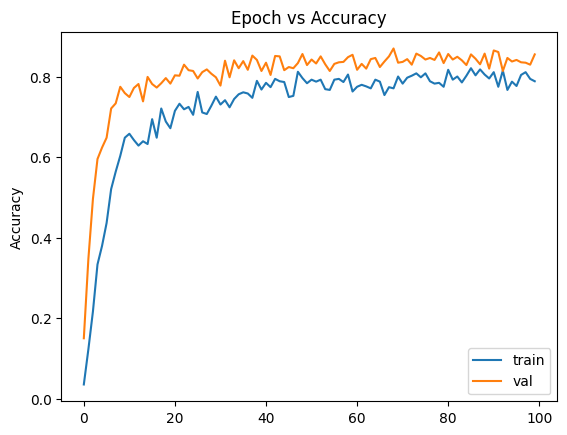

In [28]:
plot_graph(num_epochs, train_acc, val_acc, "Epoch vs Accuracy")

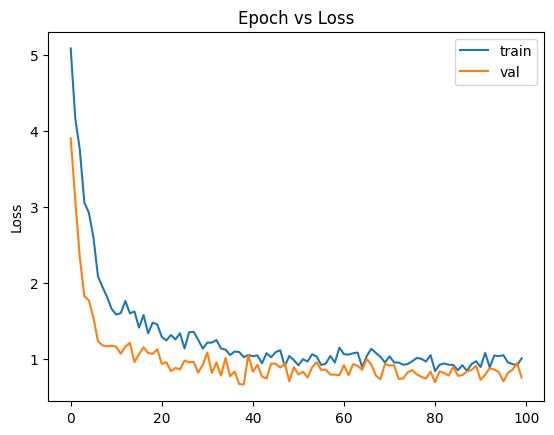

In [29]:
plot_graph(num_epochs, train_loss, val_loss, "Epoch vs Loss")

## Testing on test set

Here, we decided to test the model with only Cross Entropy Loss and Triplet Loss without the KNN Classifier. 
The model returned a result of 83.25%. It may be that the classifier did not classify accurately enough. 

In [30]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    correct = 0
    with torch.no_grad():
        for i, (inputs, anchor_label) in enumerate(dataloaders['test']):

            anchor_label = anchor_label.to(device)
            
            anchor_img, _, _ = inputs
            anchor_img = anchor_img.to(device)
            
        
            anchor_out = model(anchor_img)

            _, preds = torch.max(anchor_out, 1)

            preds = preds.to(device)

            correct += torch.sum(preds == anchor_label.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {anchor_label[0]}')

    correct = correct.double() / size
    model.train(mode=was_training)
    return correct

In [31]:
test_acc = test(model)

Predicted: 81 | True: 81
Predicted: 55 | True: 55
Predicted: 72 | True: 72
Predicted: 74 | True: 74
Predicted: 9 | True: 9
Predicted: 77 | True: 77
Predicted: 54 | True: 54
Predicted: 93 | True: 93
Predicted: 18 | True: 18
Predicted: 45 | True: 45
Predicted: 58 | True: 58
Predicted: 55 | True: 55
Predicted: 43 | True: 43
Predicted: 53 | True: 53
Predicted: 86 | True: 87
Predicted: 53 | True: 53
Predicted: 97 | True: 97
Predicted: 42 | True: 42
Predicted: 53 | True: 53
Predicted: 25 | True: 25
Predicted: 70 | True: 70
Predicted: 6 | True: 6
Predicted: 50 | True: 50
Predicted: 28 | True: 28
Predicted: 93 | True: 93
Predicted: 55 | True: 55
Predicted: 23 | True: 23
Predicted: 80 | True: 80
Predicted: 56 | True: 56
Predicted: 71 | True: 71
Predicted: 7 | True: 7
Predicted: 45 | True: 45
Predicted: 29 | True: 29
Predicted: 46 | True: 46
Predicted: 94 | True: 92
Predicted: 34 | True: 34
Predicted: 25 | True: 25
Predicted: 57 | True: 57
Predicted: 76 | True: 76
Predicted: 92 | True: 92
Predic

In [32]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.8324930883070418
